## <center> User Logs </center>

In [36]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

import csv
import time

In [37]:
# Collect Member Data

df_members = pd.read_csv('Data/members.csv')
members = pd.DataFrame(df_members['msno'])

In [38]:
# Grabbing relevant member information (~0.5GB out of the 30GB of data!)

user_data = pd.DataFrame()
for chunk in pd.read_csv('Data/user_logs.csv', chunksize=1000000):
    merged = members.merge(chunk, on='msno', how='inner')
    user_data = pd.concat([user_data, merged])

In [39]:
# Almost all members have additional information now
print str(len(members['msno'].unique())) + " unique members in Music Recommendation Challenge"
print str(len(user_data['msno'].unique())) + " users now have additional information"

34403 unique members in Music Recommendation Challenge
32880 users now have additional information


In [ ]:
# Formatted data to .csv
user_data.to_csv('Data/user_logs2.csv', index=False)

In [40]:
# Outliers

del user_data['date']
for col in user_data.columns:
    print str(user_data['msno'][user_data[col]<0].count()) + " outliers in column " + col
user_data = user_data[user_data['total_secs'] >= 0]

0 outliers in column msno
0 outliers in column num_25
0 outliers in column num_50
0 outliers in column num_75
0 outliers in column num_985
0 outliers in column num_100
0 outliers in column num_unq
1122 outliers in column total_secs


In [41]:
# Grouping and summing data by member

counts = user_data.groupby('msno')['total_secs'].count().reset_index()
counts.columns = ['msno', 'days_listened']
sums = user_data.groupby('msno').sum().reset_index()

merge = sums.merge(counts, how='inner', on='msno')

print str(np.shape(merge)) + " -- New size of data matches unique member count"
print merge.head()

(32880, 9) -- New size of data matches unique member count
                                           msno  num_25  num_50  num_75  \
0  ++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=    1746     400     317   
1  ++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=     560      72      40   
2  ++TMf3Z81LFn6nXHm753GvkF2DhAgQwRV5zn0yQsX40=      11       1       1   
3  ++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=     605     244     186   
4  ++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=     693     122      53   

   num_985  num_100  num_unq   total_secs  days_listened  
0      406    18741    18739  4880808.157            494  
1       20      802     1348   210370.197             85  
2        0       68       74    16202.834              2  
3      204     3460     3181  1032358.900            441  
4       60      725     1435   206943.022             63  


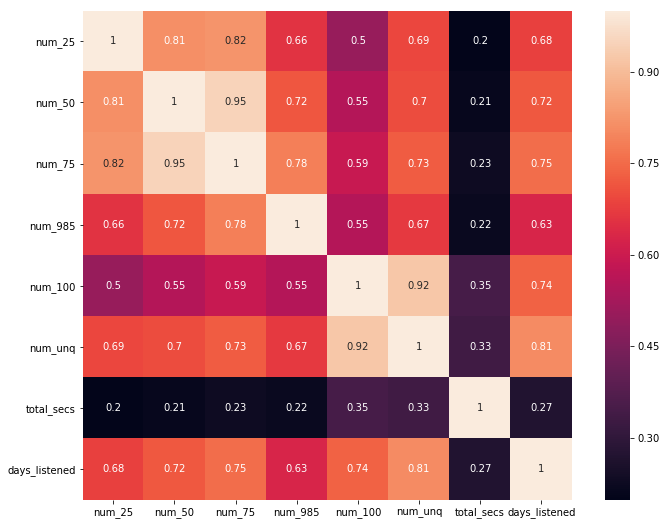

In [49]:
# Correlation Map
cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'num_25', 'days_listened']
corrmat = merge.corr()
f, ax = plt.subplots(figsize=(12, 9))
sbn.heatmap(corrmat, vmax=1, cbar=True, annot=True, square=True);
plt.show()

Although everything seems to be pretty correlated, the num_75 column and num_unq columns are the most heavily correlated and can be removed.

In [45]:
df_train = pd.read_csv('Data/train.csv')
train = df_train.merge(merge, how='left', on='msno')

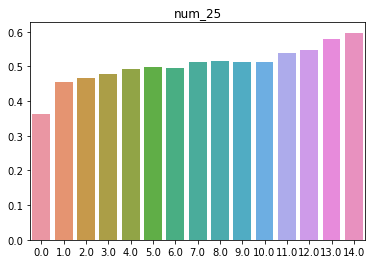

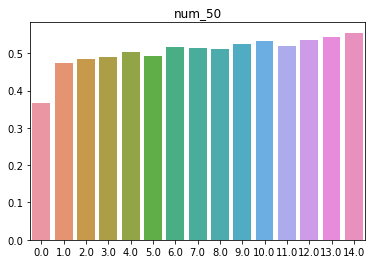

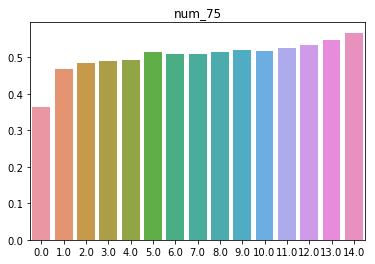

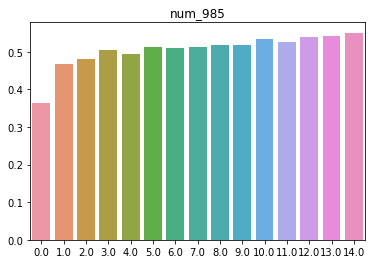

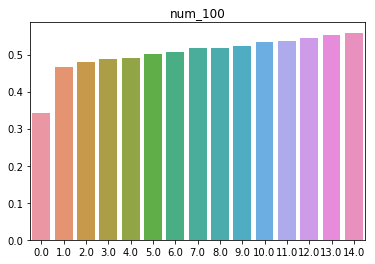

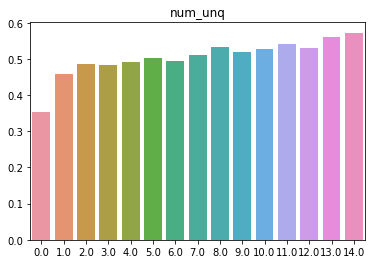

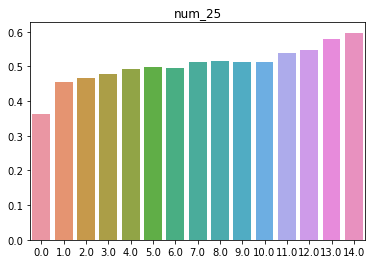

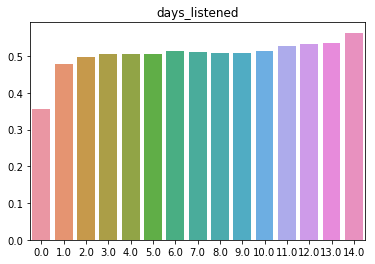

In [50]:
def repeat_chance_plot(groups, col, plot=False):
    x_axis = [] # Sort by type
    repeat = [] # % of time repeated
    for name, group in groups:
        count0 = float(group[group.target == 0][col].count())
        count1 = float(group[group.target == 1][col].count())
        percentage = count1/(count0 + count1)
        x_axis = np.append(x_axis, name)
        repeat = np.append(repeat, percentage)
    plt.figure()
    plt.title(col)
    sbn.barplot(x_axis, repeat)

for col in cols:
    tmp = pd.DataFrame(pd.qcut(train[col], 15, labels=False))
    tmp['target'] = train['target']
    groups = tmp.groupby(col)
    repeat_chance_plot(groups, col)

In [ ]:
# Normalizing and Standardizing Data

del merge['num_75']
del merge['num_unq']
del merge['msno']

cols = merge.columns[1:]
from sklearn.preprocessing import StandardScaler
merge2 = merge.copy()
merge2[cols] = np.log1p(merge[cols])
ss = StandardScaler()
merge2[cols] = ss.fit_transform(merge2[cols])

for col in merge.columns[1:]:
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    sbn.distplot(merge[col].dropna())
    plt.subplot(1,2,2)
    sbn.distplot(merge2[col].dropna())
    plt.figure()